# MC and HMC simulations of a 3-dimentional Lennard-Jones fluid

In [2]:
import numpy as np
import math
import random as rnd
import matplotlib.pyplot as plt

In [ ]:
kB = 1.0 #boltzmann constant in reduced unites, non-dimensional reduced units are used in this simulation

## Monte Carlo

In [5]:
class MCsimulator:

    def __init__(self, N=108, T=1.0, L=10.0, cutoff=2.5, N_STEPS=10000, max_displacement=0.1, N_OUTPUT = 1000):
        self.N = N #number or Argon particles, fixed
        self.T = T #temperature, fixed
        self.L = L #length of the 3-dimensional box, fixed
        # N, L and T are fixed for the whole simulation, canonical ensemble
        self.cutoff = cutoff #used when computing interactions to make the program run faster, lennard-jones potential goes to zero quite fast
        self.N_STEPS = N_STEPS #number of monte carlo steps
        self.max_displacement = max_displacement #maximum step length possible
        self.N_OUTPUT = N_OUTPUT #outputs are computed after this number of monte carlo steps, averaging
        self.cutoff2 = cutoff ** 2
        self.kBT = kB * T

        #initialize positions
        self.positions = self.initialize_positions()

        #the quantities we are interested in are the energy, the pressure and the acceptance rate

        #initialize energy and pressure
        self.kinetic_energy = 1.5 * self.N * self.kBT #from equipartition theorem
        self.potential_energy = self.compute_potential_energy() #from lennard-jones potentials
        self.total_energy = self.potential_energy + self.kinetic_energy
        self.kinetic_pressure = self.N * self.kBT / (self.L ** 3) #from ideal gas low
        self.virial_pressure = self.compute_virial_pressure() #virial component of the pressure
        self.total_pressure = self.virial_pressure + self.kinetic_pressure
        #the kinetic components characterize an ideal non-interagent gas of particles
        #the potential energy and the virial pressure take into account the presence of interactions

        self.accept_count = 0 #number of accepted moved (initialized to 0)
        self.kinetic_energies = []
        self.av_potential_energies = []
        self.av_total_energies = []
        self.kinetic_pressures = []
        self.av_virial_pressures = []
        self.av_total_pressures = []

    def initialize_positions(self): #to initialize particle positions, spread in a periodic manner to avoid overlapping and high initial energy
        positions = []
        particles_per_side = math.ceil(self.N ** (1 / 3))
        spacing = self.L / particles_per_side
        for i in range(particles_per_side):
            for j in range(particles_per_side):
                for k in range(particles_per_side):
                    if len(positions) < self.N:
                        positions.append([i * spacing + 0.5 * spacing,
                                          j * spacing + 0.5 * spacing,
                                          k * spacing + 0.5 * spacing])
        return np.array(positions)

    def minimum_image_distance(self, pos1, pos2):#to compute the minimum distance between two positions taking into account periodic boundary conditions
        delta = pos1 - pos2
        delta -= np.round(delta / self.L) * self.L
        dist2 = np.dot(delta, delta)
        return dist2, delta

    def pairEnergy(self, r):#to compute lennard-jones potential energy between two particles
        sigma = 1.0
        epsilon = 1.0
        return 4 * epsilon * (((sigma / r) ** 12) - ((sigma / r) ** 6))

    def compute_potential_energy(self):#to compute the potential energy of the whole system
        potential_energy = 0.0
        for i in range(self.N):
            for j in range(i + 1, self.N):
                rij2, _ = self.minimum_image_distance(self.positions[i], self.positions[j])
                if rij2 < self.cutoff2: #cutoff to make the program faster
                    potential_energy += self.pairEnergy(np.sqrt(rij2))
        return potential_energy

    def pairForce(self, r):#to compute lennard-jones force between two particles
        sigma = 1.0
        epsilon = 1.0
        return 24 * epsilon * (2 * ((sigma / r) ** 12) - ((sigma / r) ** 6)) / r

    def compute_virial_pressure(self):#to compute the virial pressure of the system
        virial = 0.0
        for i in range(self.N):
            for j in range(i + 1, self.N):
                rij2, delta = self.minimum_image_distance(self.positions[i], self.positions[j])
                if rij2 < self.cutoff2: #cutoff to make the program faster
                    rij = np.sqrt(rij2)
                    fij = self.pairForce(rij)
                    virial += rij * fij
        virial_pressure = virial / (3 * (self.L ** 3) )
        return virial_pressure

    def apply_pbc(self, position): #to apply periodic boundary conditions
        for i in range(len(position)):
            if position[i] >= self.L:
                position[i] -= self.L
            elif position[i] < 0:
                position[i] += self.L
        return position

    def monte_carlo_step(self): #to perform a single monte carlo step
        particle_idx = rnd.randint(0, self.N - 1) #a particle is chosen randomly
        old_position = self.positions[particle_idx].copy()
        old_energy = self.potential_energy
        d = 1e-10
        displacement = np.random.uniform(-self.max_displacement, self.max_displacement + d, size=3)
        self.positions[particle_idx] += displacement #particle is moved adding a random displacement vector
        self.positions[particle_idx] = self.apply_pbc(self.positions[particle_idx])
        new_energy = self.compute_potential_energy()
        delta_energy = new_energy - old_energy
        if delta_energy <= 0 or rnd.random() < math.exp(-delta_energy / self.kBT): #metropolis criterion
            self.potential_energy += delta_energy
            self.total_energy = self.potential_energy + self.kinetic_energy #(kinetic energy is constant)
            self.virial_pressure = self.compute_virial_pressure()
            self.total_pressure = self.virial_pressure + self.kinetic_pressure #(kinetic pressure is const)
            self.accept_count += 1
        else:
            self.positions[particle_idx] = old_position

    #IF YOU NEED TO MOVE MORE THAN ONE PARTICLE, UNCOMMENT THE FOLLOWING FUNCTION AND COMMENT THE PREVIOUS ONE
    #(YOU CAN USE THIS ONE ALSO FOR ONLY ONE PARTICLE BY JUST SETTING N_PARTICLES=1)

    #def monte_carlo_step(self, N_PARTICLES): #to perform a single monte carlo step moving N_PARTICLES
        #particle_indices = np.random.choice(range(self.N), N_PARTICLES, replace=False)
        #old_positions = [self.positions[idx].copy() for idx in particle_indices]
        #d = 1e-10
        #displacements = np.random.uniform(-self.max_displacement, self.max_displacement + d, size=(N_PARTICLES, 3))
        #for i, idx in enumerate(particle_indices):
            #self.positions[idx] += displacements[i]
            #self.positions[idx] = self.apply_pbc(self.positions[idx])
        #old_energy = self.potential_energy
        #new_energy = self.compute_potential_energy()
        #delta_energy = new_energy - old_energy
        #if delta_energy <= 0 or rnd.random() < math.exp(-delta_energy / self.kBT):
            #self.potential_energy += delta_energy
            #self.total_energy = self.potential_energy + self.kinetic_energy
            #self.virial_pressure = self.compute_virial_pressure()
            #self.total_pressure = self.virial_pressure + self.kinetic_pressure
            #self.accept_count += 1
        #else:
            #for i, idx in enumerate(particle_indices):
                #self.positions[idx] = old_positions[i]

    def simulate(self):
        print(f"You are simulating the system for {self.N_STEPS} MC steps, plotting averages every {self.N_OUTPUT} steps" )
        print(f"You are in the Canonical ensemble with: fixed number of particles: {self.N}, fixed reduced box length: {self.L}, fixed reduced temperature: {self.T}")
        print(f"Step: 0, Total energy INITIAL: {self.total_energy:.3f}, Total pressure INITIAL: {self.total_pressure:.3f}")
        potential_energies = []
        virial_pressures = []
        accept_count_tot = 0
        self.accept_ratio_list = []
        for step in range(1, self.N_STEPS+1):
            self.monte_carlo_step()  #IF YOU NEED TO MOVE MORE THAN ONE PARTICLE GIVE N_PARTICLES AS INPUT
            if step == 1: #first step
                self.kinetic_energies.append(self.kinetic_energy)
                self.av_potential_energies.append(self.potential_energy)
                self.av_total_energies.append(self.total_energy)
                self.kinetic_pressures.append(self.kinetic_pressure)
                self.av_virial_pressures.append(self.virial_pressure)
                self.av_total_pressures.append(self.total_pressure)
                print(f"Step: {step}, Total energy: {self.total_energy:.3f}, Total pressure: {self.total_pressure:.3f}, Acceptance ratio: {self.accept_count / 1}")
                self.accept_ratio_list.append(self.accept_count / 1)
            potential_energies.append(self.potential_energy)
            virial_pressures.append(self.virial_pressure)
            if step % self.N_OUTPUT == 0: #outputs are computed every N_OUTPUT steps
                av_potential_energy = sum(potential_energies) / self.N_OUTPUT
                av_virial_pressure = sum(virial_pressures) / self.N_OUTPUT
                self.kinetic_energies.append(self.kinetic_energy)
                self.av_potential_energies.append(av_potential_energy)
                self.av_total_energies.append(self.kinetic_energy + av_potential_energy)
                self.kinetic_pressures.append(self.kinetic_pressure)
                self.av_virial_pressures.append(av_virial_pressure)
                self.av_total_pressures.append(self.kinetic_pressure + av_virial_pressure)
                potential_energies = []
                virial_pressures = []
                print(f"Step: {step}, Total energy: {self.total_energy:.3f}, Total pressure: {self.total_pressure:.3f}, Accepted moves: {self.accept_count}, Acceptance ratio: {self.accept_count / self.N_OUTPUT:.3f}")
                accept_count_tot += self.accept_count #number of accepted moves
                self.accept_ratio_list.append(self.accept_count / self.N_OUTPUT)
                self.accept_count = 0
        final_av_potential_energy = sum(self.av_potential_energies[2:]) / len(self.av_potential_energies[2:])
        final_av_total_energy = sum(self.av_total_energies[2:]) / len(self.av_potential_energies[2:])
        final_av_virial_pressure = sum(self.av_virial_pressures[2:]) / len(self.av_potential_energies[2:])
        final_av_total_pressure = sum(self.av_total_pressures[2:]) / len(self.av_potential_energies[2:])
        print(f"Constant kinetic energy: {self.kinetic_energy:.3f}")
        print(f"Average potential energy: {final_av_potential_energy:.3f}")
        print(f"Average total energy: {final_av_total_energy:.3f}")
        print(f"Constant kinetic pressure: {self.kinetic_pressure:.3f}")
        print(f"Average virial pressure: {final_av_virial_pressure:.3f}")
        print(f"Average total pressure: {final_av_total_pressure:.3f}")
        print(f"Total accepted moves: {accept_count_tot:.3f}")
        print(f"Total acceptance ratio: {accept_count_tot / self.N_STEPS:.3f}")

    def plot_results(self):
        steps = np.arange(0, self.N_STEPS+1, self.N_OUTPUT)
        steps[0]=1
        plt.figure()
        plt.plot(steps, self.av_potential_energies)
        plt.xlabel("Step")
        plt.ylabel("Potential energy")
        plt.show()

        plt.figure()
        plt.plot(steps, self.kinetic_energies)
        plt.xlabel("Step")
        plt.ylabel("Kinetic energy")
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_total_energies)
        plt.xlabel("Step")
        plt.ylabel("Total energy")
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_virial_pressures)
        plt.xlabel("Step")
        plt.ylabel("Virial pressure")
        plt.show()

        plt.figure()
        plt.plot(steps, self.kinetic_pressures)
        plt.xlabel("Step")
        plt.ylabel("Kinetic pressure")
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_total_pressures)
        plt.xlabel("Step")
        plt.ylabel("Total pressure")
        plt.show()

        plt.figure()
        plt.plot(steps, self.accept_ratio_list)
        plt.xlabel("Step")
        plt.ylabel("Acceptance ratio")
        plt.show()

You are simulating the system for 20000 MC steps, plotting averages every 1000 steps
You are in the Canonical ensemble with: fixed number of particles: 100, fixed reduced box length: 4.93, fixed reduced temperature: 0.709
Step: 0, Total energy INITIAL: -140.407, Total pressure INITIAL: 18.880
Step: 1, Total energy: -140.407, Total pressure: 18.880, Acceptance ratio: 0.0
Step: 1000, Total energy: -142.930, Total pressure: 17.365, Accepted moves: 111, Acceptance ratio: 0.111
Step: 2000, Total energy: -171.398, Total pressure: 15.267, Accepted moves: 176, Acceptance ratio: 0.176
Step: 3000, Total energy: -222.843, Total pressure: 12.426, Accepted moves: 246, Acceptance ratio: 0.246
Step: 4000, Total energy: -293.803, Total pressure: 8.896, Accepted moves: 278, Acceptance ratio: 0.278
Step: 5000, Total energy: -357.468, Total pressure: 5.764, Accepted moves: 325, Acceptance ratio: 0.325
Step: 6000, Total energy: -400.465, Total pressure: 3.603, Accepted moves: 375, Acceptance ratio: 0.375


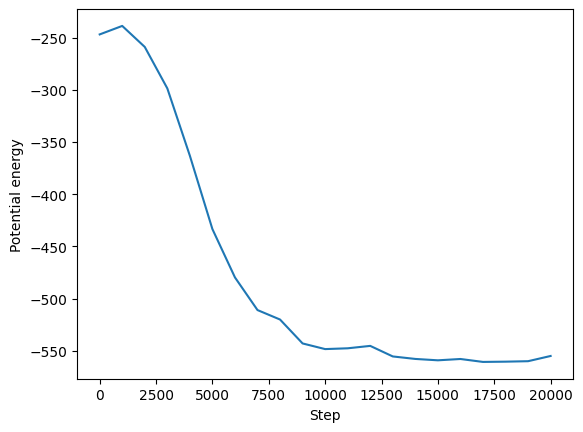

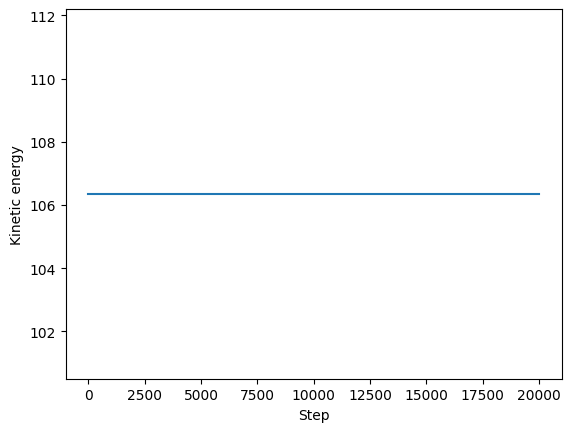

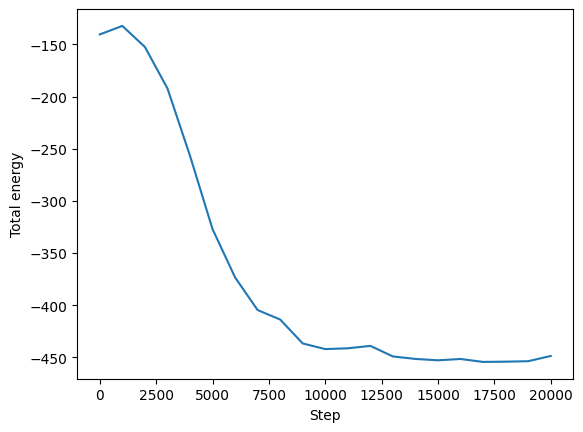

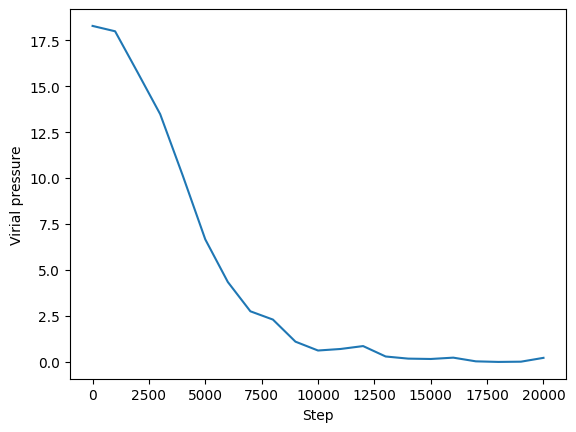

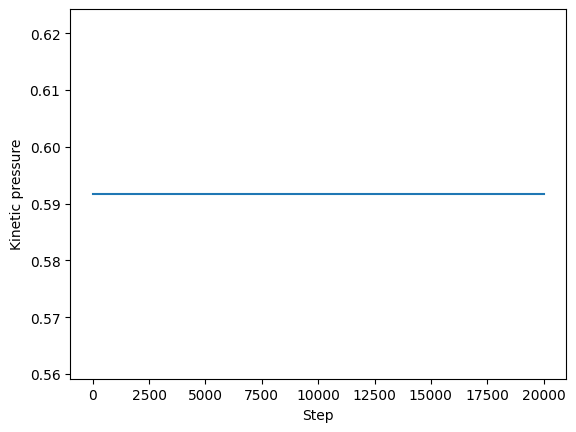

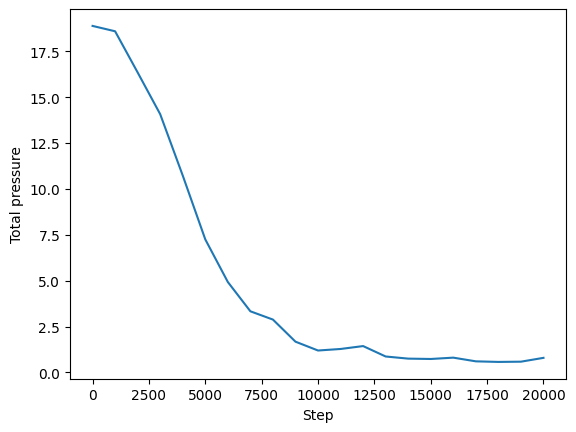

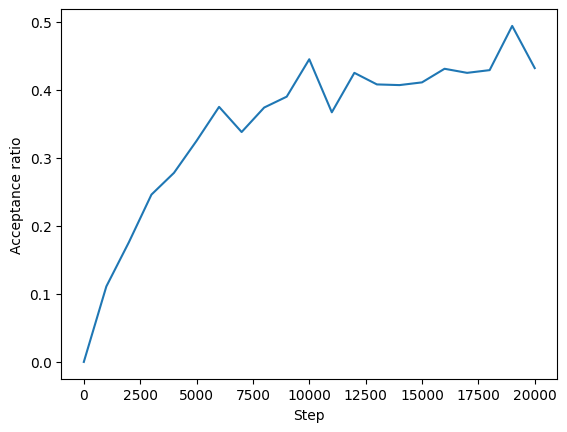

In [6]:
if __name__ == "__main__":
    simulator = MCsimulator(N=100, T=0.709, L=4.93, cutoff=2.5, N_STEPS=20000, max_displacement=0.1, N_OUTPUT=1000)
    simulator.simulate()
    simulator.plot_results()

## Hybrid Monte Carlo

In [8]:
#this simulation is in between a monte carlo method and a molecular dynamics one:
#moves are not chosen random anymore but taken from a velocity verlet integrator
#and accepted or rejected according to the metropolis criterion

class HMCsimulator:

    def __init__(self, N=108, T=1.0, L=10.0, cutoff=2.5, N_STEPS=10000, time_step=0.01, integration_steps=10, m=1.0, N_OUTPUT=1000):
        self.N = N
        self.T = T #in order to keep the temperature it constant we need a thermostat
        self.L = L
        self.cutoff = cutoff
        self.N_STEPS = N_STEPS
        self.N_OUTPUT = N_OUTPUT
        self.cutoff2 = cutoff ** 2
        self.kBT = kB * T
        self.m = m #mass
        self.time_step = time_step #single time step performed by the velocity verlet iteration
        self.integration_steps = integration_steps # the verlet iteration is then repeated this number of times for each hybid mc step

        self.positions = self.initialize_positions()
        self.velocities = self.initialize_velocities()
        self.forces = self.compute_forces()
        self.kinetic_energy = 0.5 * self.m * np.sum(self.velocities**2) #computed using the velocities
        self.potential_energy = self.compute_potential_energy()
        self.total_energy = self.potential_energy + self.kinetic_energy
        self.kinetic_pressure = self.N * self.kBT / (self.L ** 3)
        self.virial_pressure = self.compute_virial_pressure()
        self.total_pressure = self.kinetic_pressure + self.virial_pressure

        self.accept_count = 0
        self.av_kinetic_energies = []
        self.av_potential_energies = []
        self.av_total_energies = []
        self.av_kinetic_pressures = []
        self.av_virial_pressures = []
        self.av_total_pressures = []

    def initialize_positions(self): #(same as before)
        positions = []
        particles_per_side = math.ceil(self.N ** (1 / 3))
        spacing = self.L / particles_per_side
        for i in range(particles_per_side):
            for j in range(particles_per_side):
                for k in range(particles_per_side):
                    if len(positions) < self.N:
                        positions.append([i * spacing + 0.5 * spacing,
                                          j * spacing + 0.5 * spacing,
                                          k * spacing + 0.5 * spacing])
        return np.array(positions)

    def initialize_velocities(self): #velocities are drown from the maxwell-boltzmann distribution
        velocities = np.random.normal(loc=0, scale=np.sqrt(self.kBT / self.m), size=(self.N, 3))
        return velocities

    def minimum_image_distance(self, pos1, pos2): #(same as before)
        delta = pos1 - pos2
        delta -= np.round(delta / self.L) * self.L
        dist2 = np.dot(delta, delta)
        return dist2, delta

    def pairForce(self, r): #(same as before)
        sigma = 1.0
        epsilon = 1.0
        return 24 * epsilon * (2 * ((sigma / r) ** 12) - ((sigma / r) ** 6)) / r

    def compute_forces(self): #to compute forces from positions
        forces = np.zeros((self.N, 3))
        for i in range(self.N):
            for j in range(i + 1, self.N):
                rij2, delta = self.minimum_image_distance(self.positions[i], self.positions[j])
                if rij2 < self.cutoff2:
                    rij = np.sqrt(rij2)
                    fij = self.pairForce(rij) * delta / rij
                    forces[i] += fij
                    forces[j] -= fij
        return forces

    def compute_virial_pressure(self): #(same as before)
        virial = 0.0
        for i in range(self.N):
            for j in range(i + 1, self.N):
                rij2, delta = self.minimum_image_distance(self.positions[i], self.positions[j])
                if rij2 < self.cutoff2:
                    rij = np.sqrt(rij2)
                    fij = self.pairForce(rij)
                    virial += rij * fij
        virial_pressure = virial / (3 * (self.L ** 3) )
        return virial_pressure

    def pairEnergy(self, r): #(same as before)
        sigma = 1.0
        epsilon = 1.0
        return 4 * epsilon * (((sigma / r) ** 12) - ((sigma / r) ** 6))

    def compute_potential_energy(self): #(same as before)
        potential_energy = 0.0
        for i in range(self.N):
            for j in range(i + 1, self.N):
                rij2, _ = self.minimum_image_distance(self.positions[i], self.positions[j])
                if rij2 < self.cutoff2:
                    potential_energy += self.pairEnergy(np.sqrt(rij2))
        return potential_energy

    def apply_pbc(self, position): #(same as before)
        for i in range(len(position)):
            if position[i] >= self.L:
                position[i] -= self.L
            elif position[i] < 0:
                position[i] += self.L
        return position

    def velocity_verlet(self): #to implement the velocity verlet iteration for a single step
        self.velocities += 0.5 * self.forces * self.time_step / self.m
        self.positions += self.velocities * self.time_step
        self.positions = np.array([self.apply_pbc(pos) for pos in self.positions])
        self.forces = self.compute_forces()
        self.velocities += 0.5 * self.forces * self.time_step / self.m

    def hmc_step(self):#to perform a single hybrid monte carlo step
        initial_positions = self.positions.copy()
        initial_velocities = self.velocities.copy()
        initial_forces = self.forces.copy()
        initial_energy = self.total_energy
        for _ in range(self.integration_steps):
            self.velocity_verlet()
        final_energy = self.compute_potential_energy() + 0.5 * self.m * np.sum(self.velocities**2)
        delta_energy = final_energy - initial_energy
        if delta_energy <= 0 or rnd.random() < math.exp(-delta_energy / self.kBT): #metropolis criterion as before
            self.potential_energy = self.compute_potential_energy()
            self.kinetic_energy = 0.5 * self.m * np.sum(self.velocities ** 2)
            self.total_energy = self.potential_energy + self.kinetic_energy #(now also kinetc energy changes)
            self.virial_pressure = self.compute_virial_pressure()
            self.total_pressure = self.kinetic_pressure + self.virial_pressure #(kinetic pressure is const)
            self.accept_count += 1
        else:
            self.positions = initial_positions
            self.velocities = initial_velocities
            self.forces = initial_forces

    def simulate(self):
        print(f"Step: 0, Total energy INITIAL: {self.total_energy:.3f}")
        potential_energies = []
        kinetic_energies = []
        virial_pressures = []
        kinetic_pressures = []
        accept_count_tot = 0
        self.accept_ratio_list = []
        for step in range(1, self.N_STEPS+1):
            if step % N_THERMO == 0: #anderson thermostat!!
                #every N_THERMO steps all velocities are replaced by new ones form maxwell-boltzmann distribution (done by initialize_velocities())
                self.velocities = self.initialize_velocities()
                self.kinetic_energy = 0.5 * self.m * np.sum(self.velocities ** 2)
                self.total_energy = self.potential_energy + self.kinetic_energy
            self.hmc_step()
            if step == 1:
                self.av_kinetic_energies.append(self.kinetic_energy)
                self.av_potential_energies.append(self.potential_energy)
                self.av_total_energies.append(self.total_energy)
                self.av_kinetic_pressures.append(self.kinetic_pressure)
                self.av_virial_pressures.append(self.virial_pressure)
                self.av_total_pressures.append(self.total_pressure)
                print(f"Step: {step}, Total energy: {self.total_energy:.3f}, Total pressure: {self.total_pressure:.3f}, Acceptance ratio: {self.accept_count / 1}")
                self.accept_ratio_list.append(self.accept_count / 1)
            potential_energies.append(self.potential_energy)
            kinetic_energies.append(self.kinetic_energy)
            virial_pressures.append(self.virial_pressure)
            kinetic_pressures.append(self.kinetic_pressure)
            if step % self.N_OUTPUT == 0:
                av_potential_energy = sum(potential_energies) / self.N_OUTPUT
                av_kinetic_energy = sum(kinetic_energies) / self.N_OUTPUT
                av_virial_pressure = sum(virial_pressures) / self.N_OUTPUT
                av_kinetic_pressure = sum(kinetic_pressures) / self.N_OUTPUT
                self.av_kinetic_energies.append(av_kinetic_energy)
                self.av_potential_energies.append(av_potential_energy)
                self.av_total_energies.append(av_kinetic_energy + av_potential_energy)
                self.av_kinetic_pressures.append(av_kinetic_pressure)
                self.av_virial_pressures.append(av_virial_pressure)
                self.av_total_pressures.append(av_kinetic_pressure + av_virial_pressure)
                potential_energies = []
                kinetic_energies = []
                virial_pressures = []
                kinetic_pressures = []
                print(f"Step: {step}, Total energy: {self.total_energy:.3f}, Total pressure: {self.total_pressure:.3f}, Accepted moves: {self.accept_count}, Acceptance ratio: {self.accept_count / self.N_OUTPUT:.3f}")
                accept_count_tot += self.accept_count
                self.accept_ratio_list.append(self.accept_count / self.N_OUTPUT)
                self.accept_count = 0
        final_av_potential_energy = sum(self.av_potential_energies[5:]) / len(self.av_potential_energies[5:])
        final_av_kinetic_energy = sum(self.av_kinetic_energies[5:]) / len(self.av_potential_energies[5:])
        final_av_total_energy = sum(self.av_total_energies[5:]) / len(self.av_potential_energies[5:])
        final_av_virial_pressure = sum(self.av_virial_pressures[5:]) / len(self.av_potential_energies[5:])
        final_av_kinetic_pressure = sum(self.av_kinetic_pressures[5:]) / len(self.av_potential_energies[5:])
        final_av_total_pressure = sum(self.av_total_pressures[5:]) / len(self.av_potential_energies[5:])
        print(f"Average kinetic energy: {final_av_kinetic_energy:.3f}")
        print(f"Average potential energy: {final_av_potential_energy:.3f}")
        print(f"Average total energy: {final_av_total_energy:.3f}")
        print(f"Average kinetic pressure: {final_av_kinetic_pressure:.3f}")
        print(f"Average virial pressure: {final_av_virial_pressure:.3f}")
        print(f"Average total pressure: {final_av_total_pressure:.3f}")
        print(f"Total accepted moves: {accept_count_tot:.3f}")
        print(f"Total acceptance ratio: {accept_count_tot / self.N_STEPS:.3f}")

    def plot_results(self):
        steps = np.arange(0, self.N_STEPS + 1, self.N_OUTPUT)
        steps[0] = 1
        const_kinetic_energies = np.ones(len(steps)) * 1.5 * self.N * self.kBT

        plt.figure()
        plt.plot(steps, self.av_potential_energies)
        plt.xlabel("Step")
        plt.ylabel("Potential energy")
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_kinetic_energies)
        plt.plot(steps, const_kinetic_energies , label='constant')
        plt.xlabel("Step")
        plt.ylabel("Kinetic energy")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_total_energies)
        plt.xlabel("Step")
        plt.ylabel("Total energy")
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_virial_pressures)
        plt.xlabel("Step")
        plt.ylabel("Virial pressure")
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_kinetic_pressures)
        plt.xlabel("Step")
        plt.ylabel("Kinetic pressure")
        plt.show()

        plt.figure()
        plt.plot(steps, self.av_total_pressures)
        plt.xlabel("Step")
        plt.ylabel("Total pressure")
        plt.show()

        plt.figure()
        plt.plot(steps, self.accept_ratio_list)
        plt.xlabel("Step")
        plt.ylabel("Acceptance ratio")
        plt.show()

Step: 0, Total energy INITIAL: -131.608
Step: 1, Total energy: -131.216, Total pressure: 19.195, Acceptance ratio: 1.0
Step: 1000, Total energy: -307.781, Total pressure: 6.880, Accepted moves: 583, Acceptance ratio: 0.583
Step: 2000, Total energy: -400.646, Total pressure: 3.056, Accepted moves: 860, Acceptance ratio: 0.860
Step: 3000, Total energy: -440.203, Total pressure: 1.330, Accepted moves: 925, Acceptance ratio: 0.925
Step: 4000, Total energy: -451.584, Total pressure: 1.473, Accepted moves: 946, Acceptance ratio: 0.946
Step: 5000, Total energy: -443.720, Total pressure: 0.766, Accepted moves: 942, Acceptance ratio: 0.942
Step: 6000, Total energy: -449.857, Total pressure: 0.447, Accepted moves: 939, Acceptance ratio: 0.939
Step: 7000, Total energy: -444.420, Total pressure: 0.648, Accepted moves: 942, Acceptance ratio: 0.942
Step: 8000, Total energy: -423.249, Total pressure: 0.923, Accepted moves: 945, Acceptance ratio: 0.945
Step: 9000, Total energy: -441.837, Total pressur

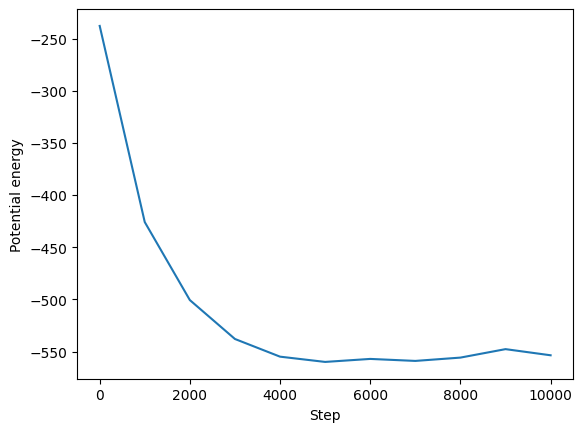

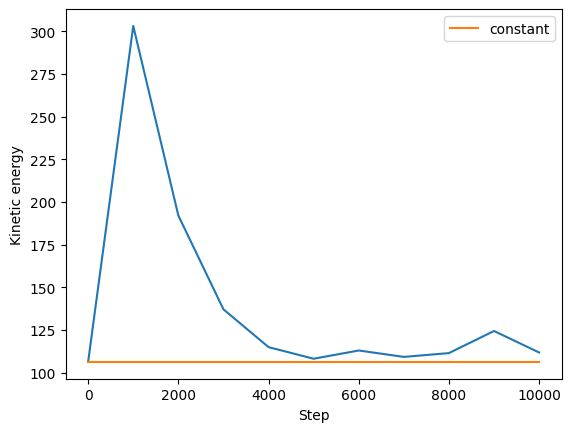

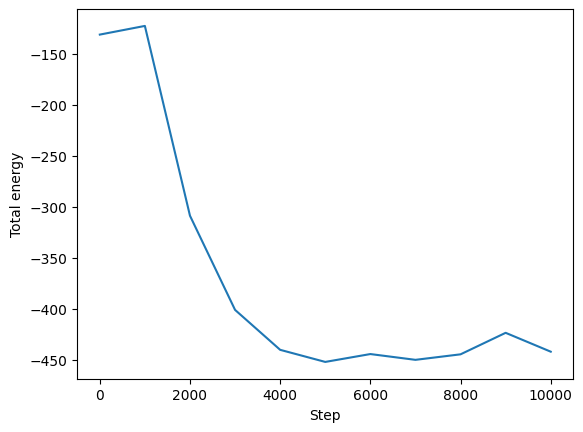

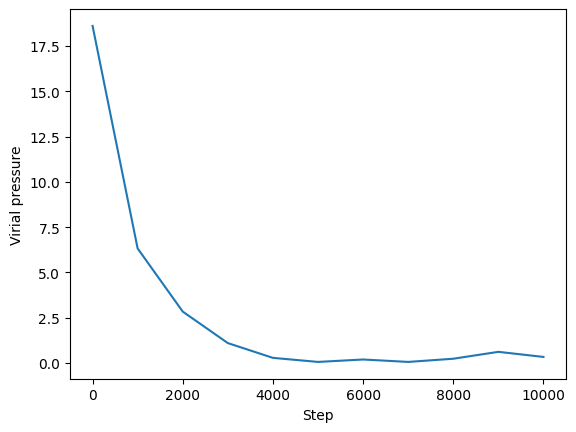

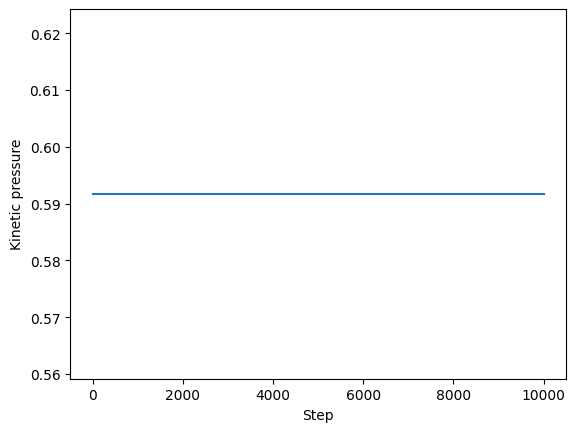

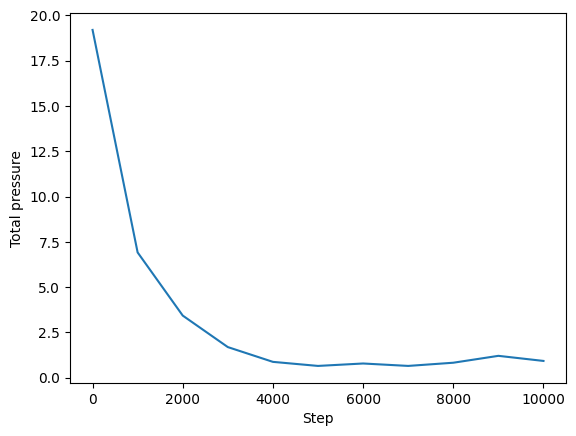

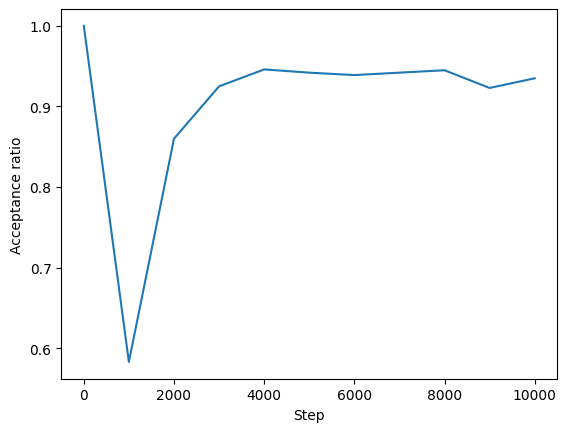

In [9]:
if __name__ == "__main__":
    N_THERMO = 1000 #every N_THERMO steps all velocities are replaced by new ones form maxwell-boltzmann distribution
    simulator = HMCsimulator(N=100, T=0.709, L=4.93, cutoff=2.5, N_STEPS=10000, time_step=0.01, integration_steps=1, N_OUTPUT=1000)
    simulator.simulate()
    simulator.plot_results()